In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import mobilenet_v2
import os
import matplotlib.pyplot as plt
import numpy as np

# Define dataset path
data_dir = "realwaste-main\\RealWaste"  # Change this to your dataset location

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Reduce image size for faster processing
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes  # Class names

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders with optimized settings for CPU training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

# Load Pretrained MobileNetV2 model
model = mobilenet_v2(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))  # Adjust output layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1):  # Reduced to 1 epoch for speed
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total * 100
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")
        
    print("Training complete!")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)  # Only 1 epoch for speed

# Validation accuracy
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    print(f"Validation Accuracy: {correct / total * 100:.2f}%")

evaluate_model(model, val_loader)


c:\Users\amogh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\amogh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss: 1.0565, Accuracy: 63.56%
Training complete!
Validation Accuracy: 73.61%


In [83]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    """
    Visualize images with their predictions and actual labels
    
    Args:
        model: trained PyTorch model
        dataloader: DataLoader containing images to visualize
        class_names: list of class names
        num_images: number of images to visualize
    """
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 12))
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu()
            
            for i in range(len(images)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                
                # Get the image and denormalize it
                img = images[i].cpu().numpy().transpose(1, 2, 0)
                # Denormalize from [-1, 1] back to [0, 1]
                img = img * 0.5 + 0.5
                
                # Get the true and predicted labels
                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]
                
                # Set color for the title based on correct/incorrect prediction
                color = 'green' if pred_label == true_label else 'red'
                
                # Plot the image
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
                
                images_shown += 1
            
            if images_shown >= num_images:
                plt.tight_layout()
                plt.show()
                return

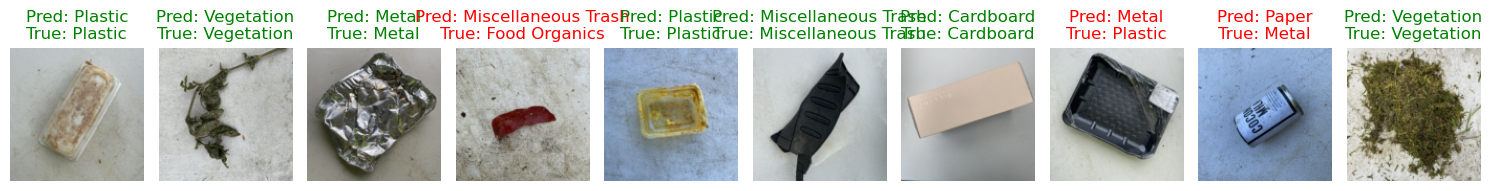

In [84]:
# Display predictions on some validation images
visualize_predictions(model, val_loader, class_names, num_images=10)

In [85]:
def iou(boxA, boxB):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes.
    
    Parameters:
    - boxA, boxB: Bounding boxes in (x_min, y_min, x_max, y_max) format.
    
    Returns:
    - IoU value (float between 0 and 1)
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute intersection area
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute areas of each box
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute union area
    unionArea = boxAArea + boxBArea - interArea

    # Compute IoU
    iou = interArea / unionArea if unionArea > 0 else 0
    return iou

In [86]:
def approximate_multi_object_detection(model, image_path, class_names, window_sizes=[32, 48, 64], stride=16, conf_threshold=0.7):
    """
    Approximate multi-object detection using a classification model with smaller sliding windows
    
    Args:
        model: Trained classification model
        image_path: Path to the image
        class_names: List of class names
        window_sizes: List of window sizes to use (smaller windows for smaller objects)
        stride: Step size for sliding window
        conf_threshold: Confidence threshold for detection
    """
    from PIL import Image
    
    # Load image
    original_img = Image.open(image_path)
    original_width, original_height = original_img.size
    
    # Create transform for sliding windows
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to model's expected input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Set model to evaluation mode
    model.eval()
    
    # Store detections
    detections = []
    
    # Use multiple window sizes
    for window_size in window_sizes:
        # Sliding window approach
        for y in range(0, original_height - window_size, stride):
            for x in range(0, original_width - window_size, stride):
                # Crop window
                window = original_img.crop((x, y, x + window_size, y + window_size))
                
                # Transform window
                window_tensor = transform(window).unsqueeze(0).to(device)
                
                # Get prediction
                with torch.no_grad():
                    outputs = model(window_tensor)
                    probs = torch.nn.functional.softmax(outputs, dim=1)
                    conf, pred_class = probs.max(1)
                
                # Skip background class if it exists
                class_idx = pred_class.item()
                if class_names[class_idx].lower() in ['background', 'none']:
                    continue
                
                # If confidence exceeds threshold, store detection
                if conf.item() > conf_threshold:
                    detections.append({
                        'box': [x, y, x + window_size, y + window_size],
                        'class': class_names[class_idx],
                        'confidence': conf.item(),
                        'size': window_size  # Store window size for visualization
                    })
    
    # Non-maximum suppression (simplified)
    final_detections = []
    detections.sort(key=lambda x: x['confidence'], reverse=True)
    
    while detections:
        best = detections.pop(0)
        final_detections.append(best)
        
        # Remove overlapping boxes with significant overlap
        detections = [det for det in detections if iou(best['box'], det['box']) < 0.3]
    
    # Display results
    plt.figure(figsize=(12, 12))
    img = np.array(original_img)
    plt.imshow(img)
    
    # Create a color map for different classes
    import matplotlib.colors as mcolors
    colors = list(mcolors.TABLEAU_COLORS.values())
    class_to_color = {cls: colors[i % len(colors)] for i, cls in enumerate(class_names)}
    
    for det in final_detections:
        x1, y1, x2, y2 = det['box']
        class_name = det['class']
        color = class_to_color.get(class_name, 'red')
        
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                          fill=False, edgecolor=color, linewidth=2)
        )
        plt.text(x1, y1-5, f"{class_name}: {det['confidence']:.2f}", 
                color='white', backgroundcolor=color, fontsize=8)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return final_detections

In [79]:
# Example usage with smaller windows
'''
image_path = "rubbish-mound-overflowing-on-patio.webp"
detections = approximate_multi_object_detection(
    model, 
    image_path, 
    class_names, 
    window_sizes=[32, 48, 64],  # Use smaller windows
    stride=16,                  # Smaller stride for more detections
    conf_threshold=0.6          # Might need to adjust this based on results
)
'''

'\nimage_path = "rubbish-mound-overflowing-on-patio.webp"\ndetections = approximate_multi_object_detection(\n    model, \n    image_path, \n    class_names, \n    window_sizes=[32, 48, 64],  # Use smaller windows\n    stride=16,                  # Smaller stride for more detections\n    conf_threshold=0.6          # Might need to adjust this based on results\n)\n'

In [77]:
'''import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from torchvision import transforms

# Create images directory if it doesn't exist
images_dir = "images"
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
    print(f"Created directory: {images_dir}")

def focus_on_center(image_path, center_ratio=0.6, output_dir="images"):
    """
    Focus on the center part of an image by cropping out a central region
    
    Args:
        image_path: Path to the input image
        center_ratio: Ratio of the original image to keep (0.6 means keep the central 60%)
        output_dir: Directory to save the cropped image
        
    Returns:
        PIL Image cropped to the center and path to saved image
    """
    # Load the image
    input_image = Image.open(image_path).convert('RGB')
    w, h = input_image.size
    
    # Calculate crop dimensions
    new_width = int(w * center_ratio)
    new_height = int(h * center_ratio)
    
    # Calculate crop coordinates
    left = (w - new_width) // 2
    top = (h - new_height) // 2
    right = left + new_width
    bottom = top + new_height
    
    # Crop the image
    center_cropped = input_image.crop((left, top, right, bottom))
    
    # Create output path in the images directory
    img_filename = os.path.basename(image_path)
    center_output_path = os.path.join(output_dir, f"center_{img_filename}")
    
    # Save the cropped image
    center_cropped.save(center_output_path)
    print(f"Center-cropped image saved to {center_output_path}")
    
    return center_cropped, center_output_path

# Further crop the center into smaller segments for better classification
def segment_center(image_path, grid_size=(2, 2), output_dir="images", output_prefix="segment_"):
    """
    Divide the center-cropped image into smaller segments for classification
    
    Args:
        image_path: Path to the center-cropped image
        grid_size: Tuple defining the grid (rows, cols)
        output_dir: Directory to save the segmented images
        output_prefix: Prefix for output segment files
        
    Returns:
        List of paths to the segmented images
    """
    # Load the image
    input_image = Image.open(image_path).convert('RGB')
    w, h = input_image.size
    
    # Calculate segment dimensions
    seg_width = w // grid_size[1]
    seg_height = h // grid_size[0]
    
    segment_paths = []
    img_filename = os.path.basename(image_path)
    
    # Create segments
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Calculate coordinates
            left = j * seg_width
            top = i * seg_height
            right = left + seg_width
            bottom = top + seg_height
            
            # Crop the segment
            segment = input_image.crop((left, top, right, bottom))
            
            # Save the segment to the images directory
            segment_path = os.path.join(output_dir, f"{output_prefix}{i}_{j}_{img_filename}")
            segment.save(segment_path)
            segment_paths.append(segment_path)
            print(f"Saved segment to {segment_path}")
    
    return segment_paths

# Process the image
image_path = "rubbish-mound-overflowing-on-patio.webp"

# Step 1: Focus on the center
print("Focusing on center of image...")
center_img, center_path = focus_on_center(image_path, center_ratio=0.7, output_dir=images_dir)

# Step 2: Segment the center into a grid (optional)
print("\nSegmenting center into a grid...")
segment_paths = segment_center(center_path, grid_size=(2, 2), output_dir=images_dir)

# Step 3: Visualize the results
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(Image.open(image_path))
plt.title("Original Image")
plt.axis('off')

# Center-cropped image
plt.subplot(2, 3, 2)
plt.imshow(center_img)
plt.title("Center-Cropped")
plt.axis('off')

# Segments
for i, seg_path in enumerate(segment_paths):
    plt.subplot(2, 3, i+3)
    plt.imshow(Image.open(seg_path))
    plt.title(f"Segment {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Step 4: Run detection on each segment
print("\nRunning detection on each segment...")
all_detections = []

for i, segment_path in enumerate(segment_paths):
    print(f"\nProcessing segment {i+1}...")
    detections = approximate_multi_object_detection(
        model, 
        segment_path, 
        class_names, 
        window_sizes=[32, 48, 64],  # Use smaller windows
        stride=16,                  # Smaller stride for more detections
        conf_threshold=0.6          # Might need to adjust this based on results
    )
    all_detections.extend(detections)

print(f"\nTotal detections across all segments: {len(all_detections)}")
'''

'import torch\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom PIL import Image\nimport cv2\nimport os\nfrom torchvision import transforms\n\n# Create images directory if it doesn\'t exist\nimages_dir = "images"\nif not os.path.exists(images_dir):\n    os.makedirs(images_dir)\n    print(f"Created directory: {images_dir}")\n\ndef focus_on_center(image_path, center_ratio=0.6, output_dir="images"):\n    """\n    Focus on the center part of an image by cropping out a central region\n    \n    Args:\n        image_path: Path to the input image\n        center_ratio: Ratio of the original image to keep (0.6 means keep the central 60%)\n        output_dir: Directory to save the cropped image\n        \n    Returns:\n        PIL Image cropped to the center and path to saved image\n    """\n    # Load the image\n    input_image = Image.open(image_path).convert(\'RGB\')\n    w, h = input_image.size\n    \n    # Calculate crop dimensions\n    new_width = int(w * center_ratio)\n    new_h



Analyzing waste types in each segment and overall...

Processing segment 1...


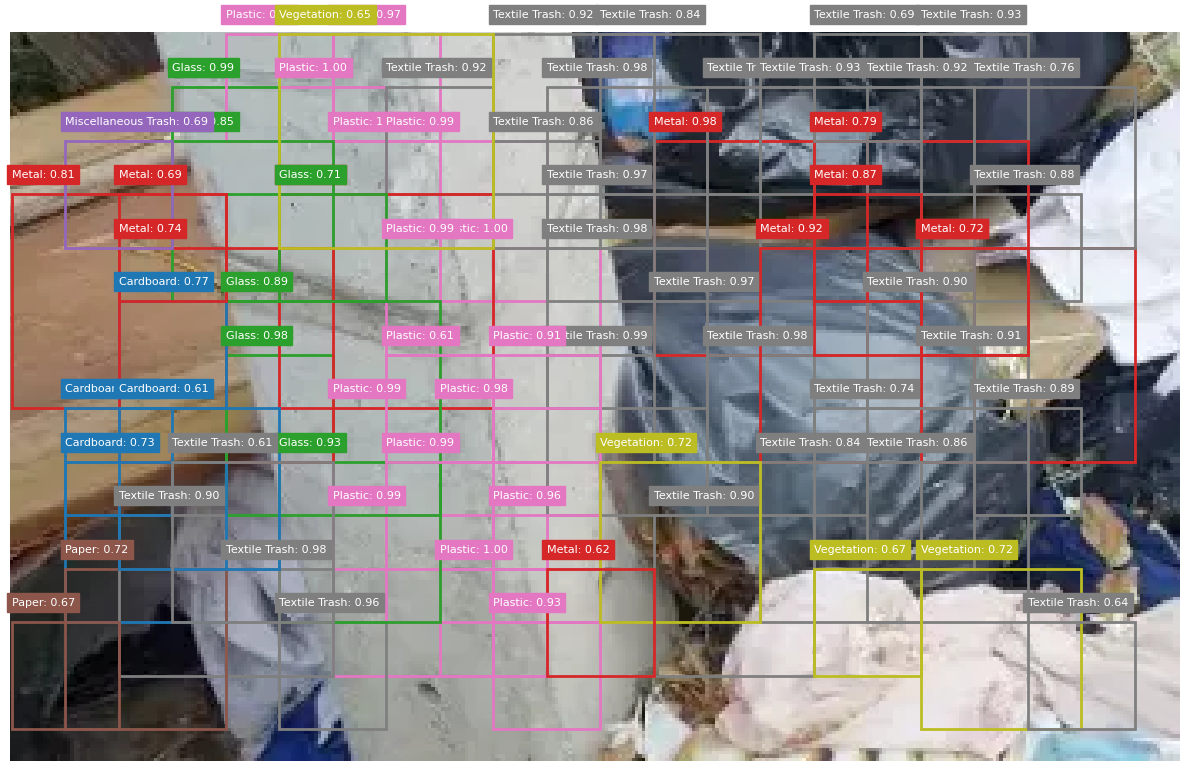


Processing segment 2...


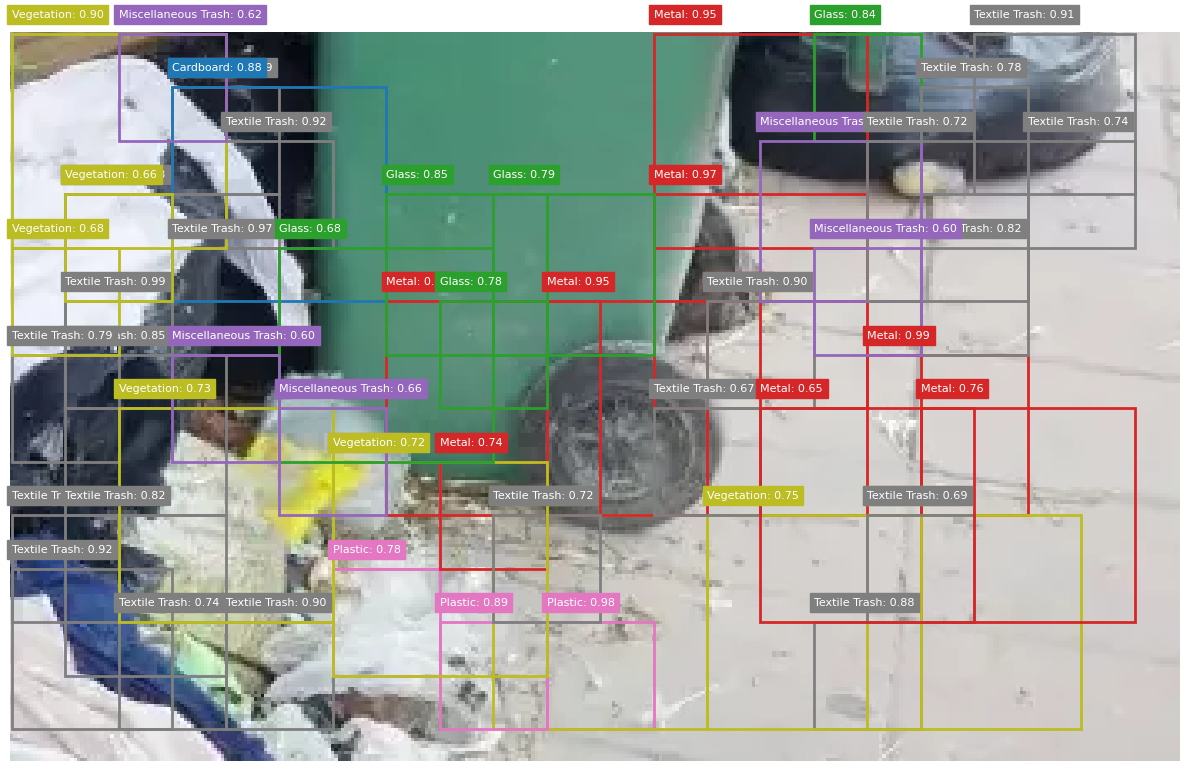


Processing segment 3...


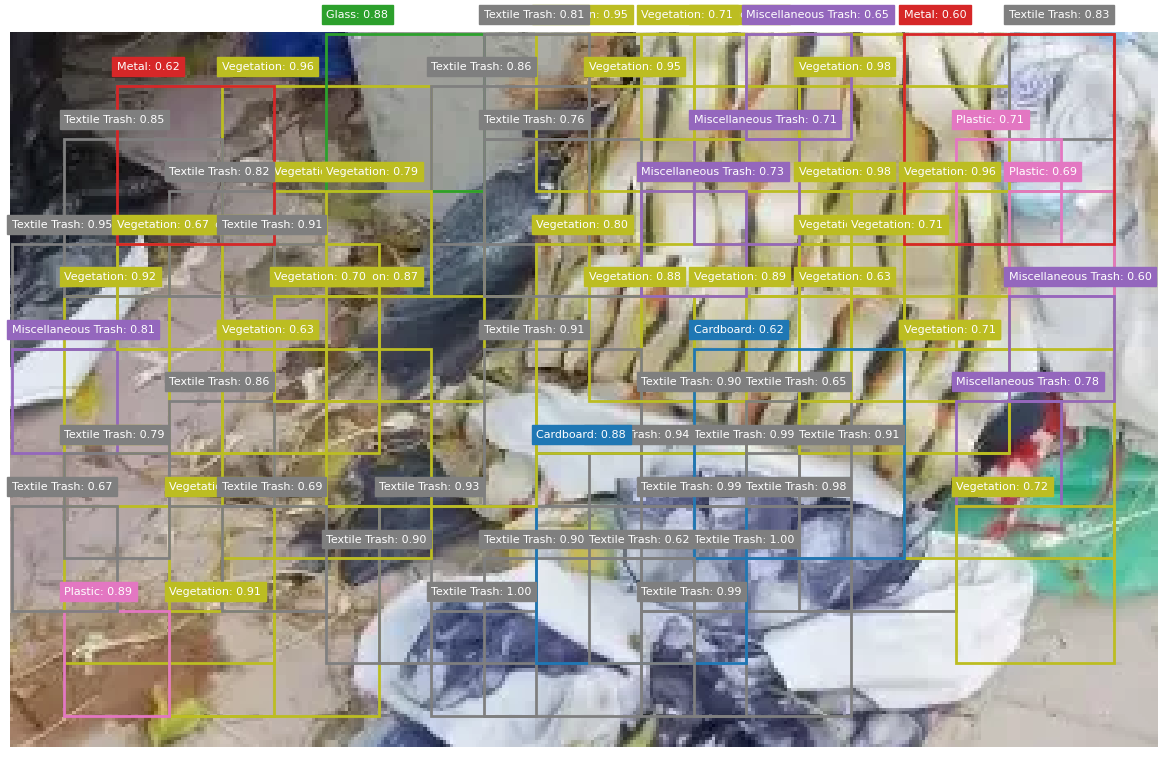


Processing segment 4...


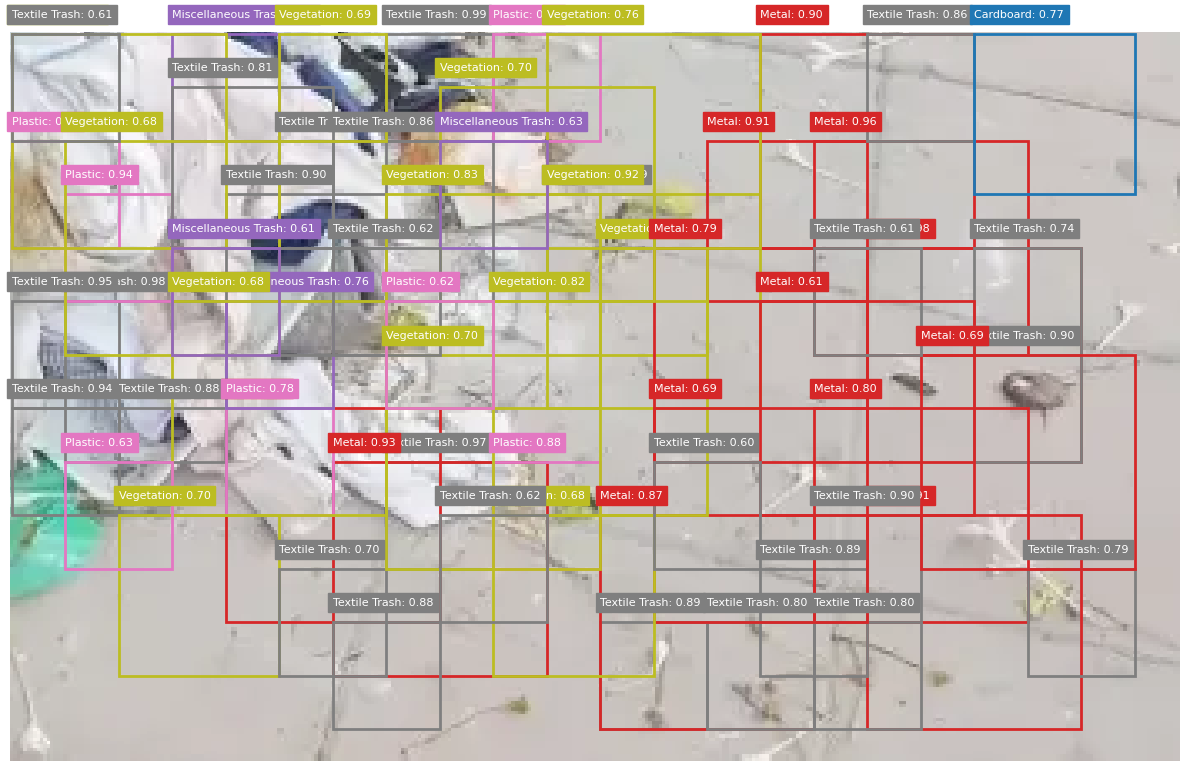



Analyzing Segment 1...

===== Segment 1: Waste Analysis Results =====
Total objects detected: 73
Most common waste type: Textile Trash (29 objects, 39.7%)

Detailed breakdown:
         Waste Type  Count  Percentage
      Textile Trash     29   39.726027
            Plastic     16   21.917808
              Metal     11   15.068493
              Glass      6    8.219178
          Cardboard      4    5.479452
         Vegetation      4    5.479452
              Paper      2    2.739726
Miscellaneous Trash      1    1.369863


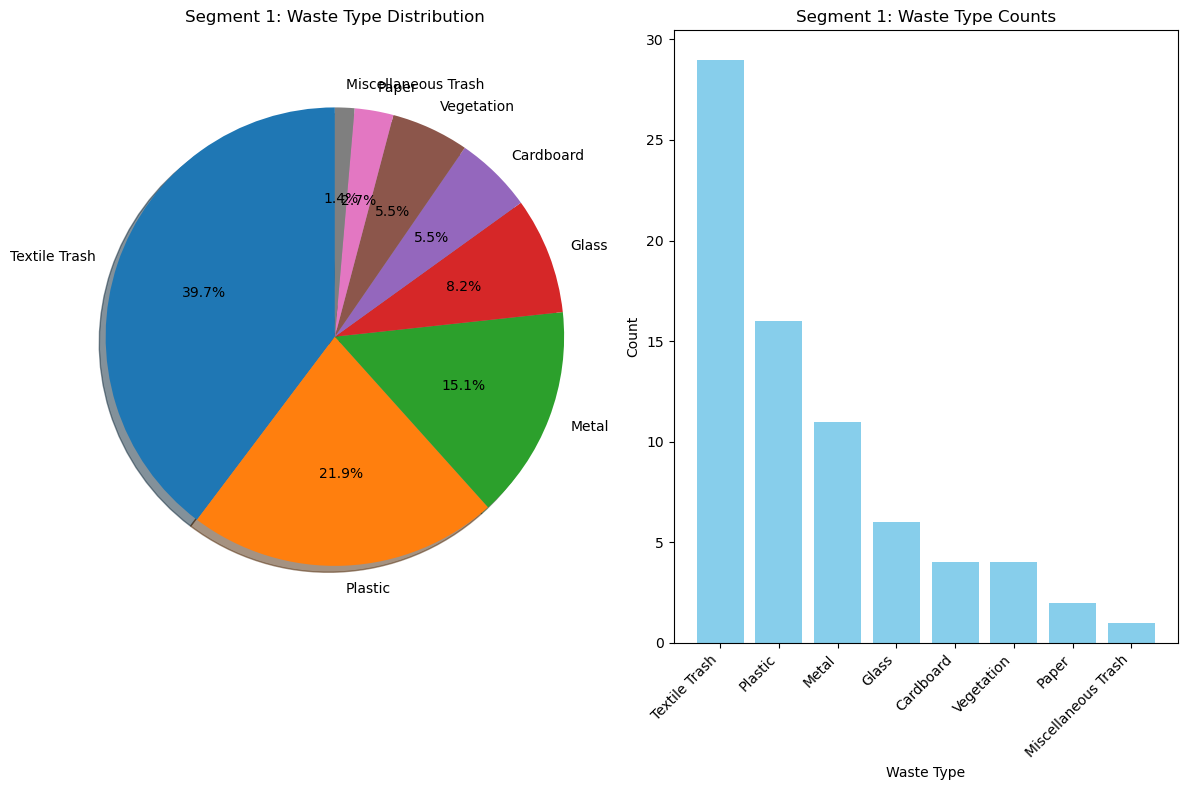

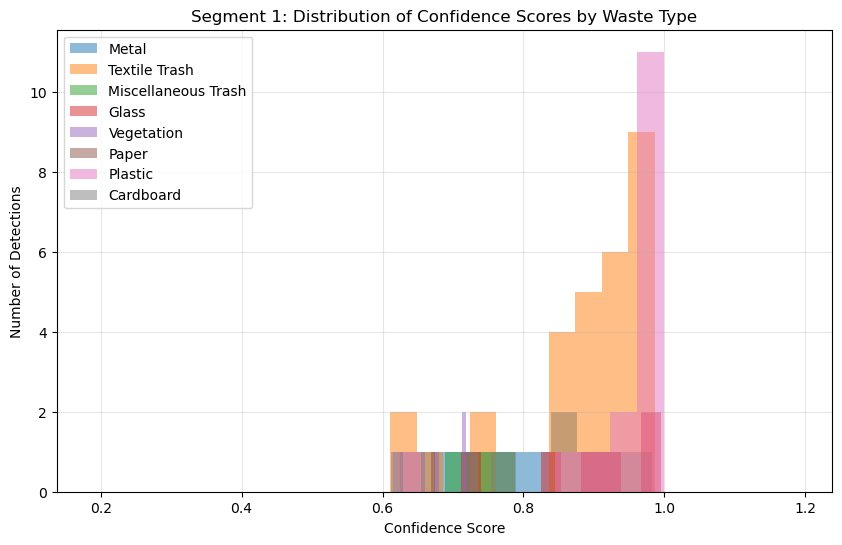



Analyzing Segment 2...

===== Segment 2: Waste Analysis Results =====
Total objects detected: 54
Most common waste type: Textile Trash (22 objects, 40.7%)

Detailed breakdown:
         Waste Type  Count  Percentage
      Textile Trash     22   40.740741
              Metal      9   16.666667
         Vegetation      8   14.814815
              Glass      5    9.259259
Miscellaneous Trash      5    9.259259
            Plastic      4    7.407407
          Cardboard      1    1.851852


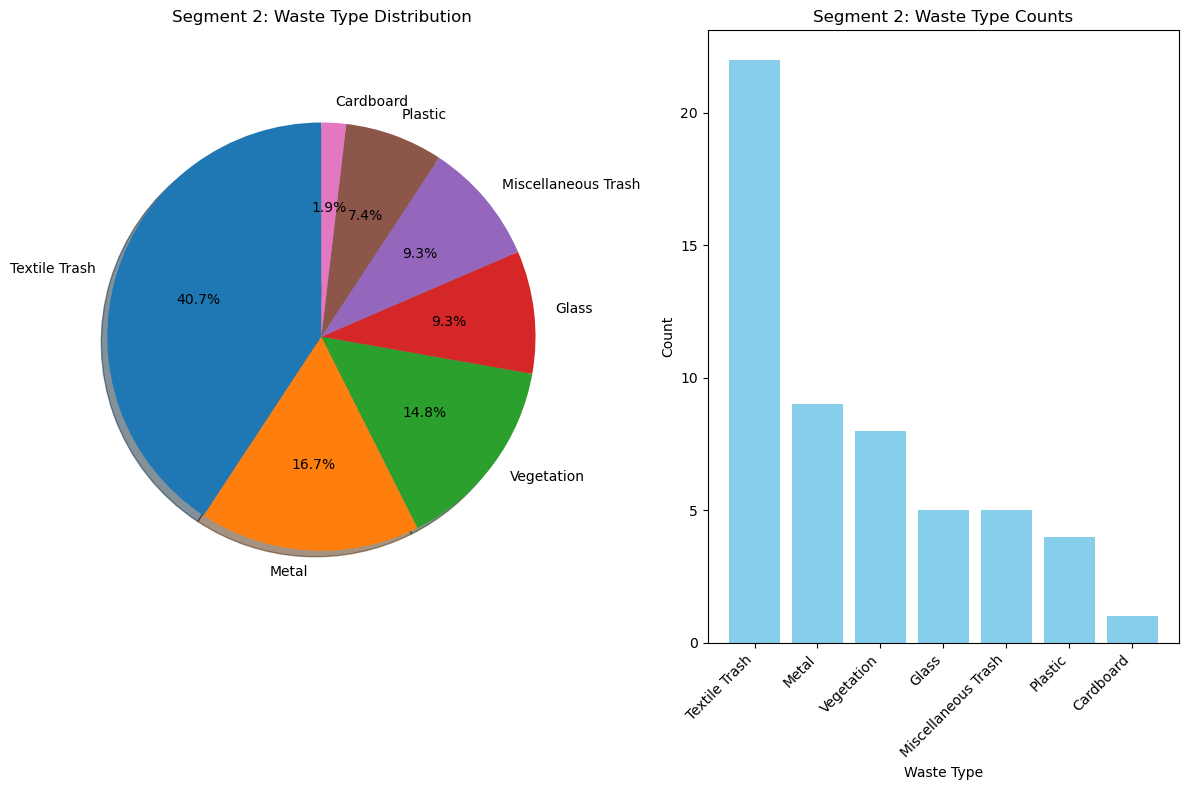

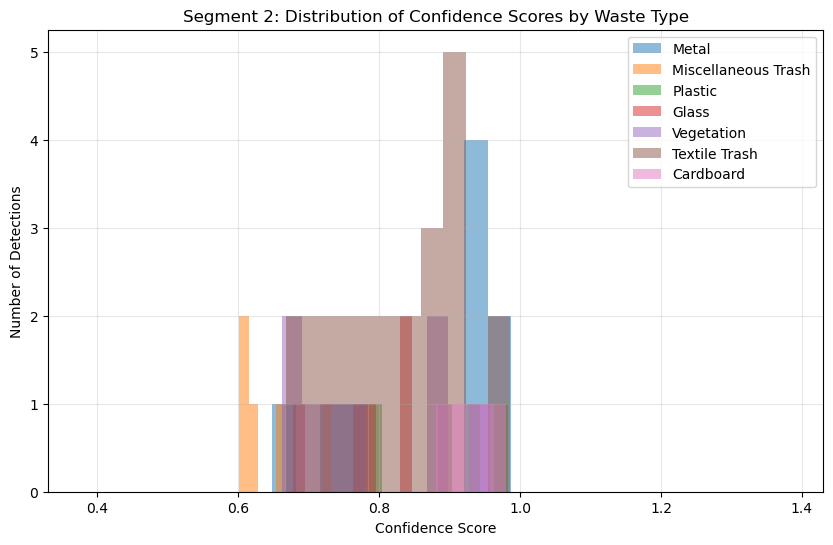



Analyzing Segment 3...

===== Segment 3: Waste Analysis Results =====
Total objects detected: 71
Most common waste type: Vegetation (30 objects, 42.3%)

Detailed breakdown:
         Waste Type  Count  Percentage
         Vegetation     30   42.253521
      Textile Trash     27   38.028169
Miscellaneous Trash      6    8.450704
            Plastic      3    4.225352
          Cardboard      2    2.816901
              Metal      2    2.816901
              Glass      1    1.408451


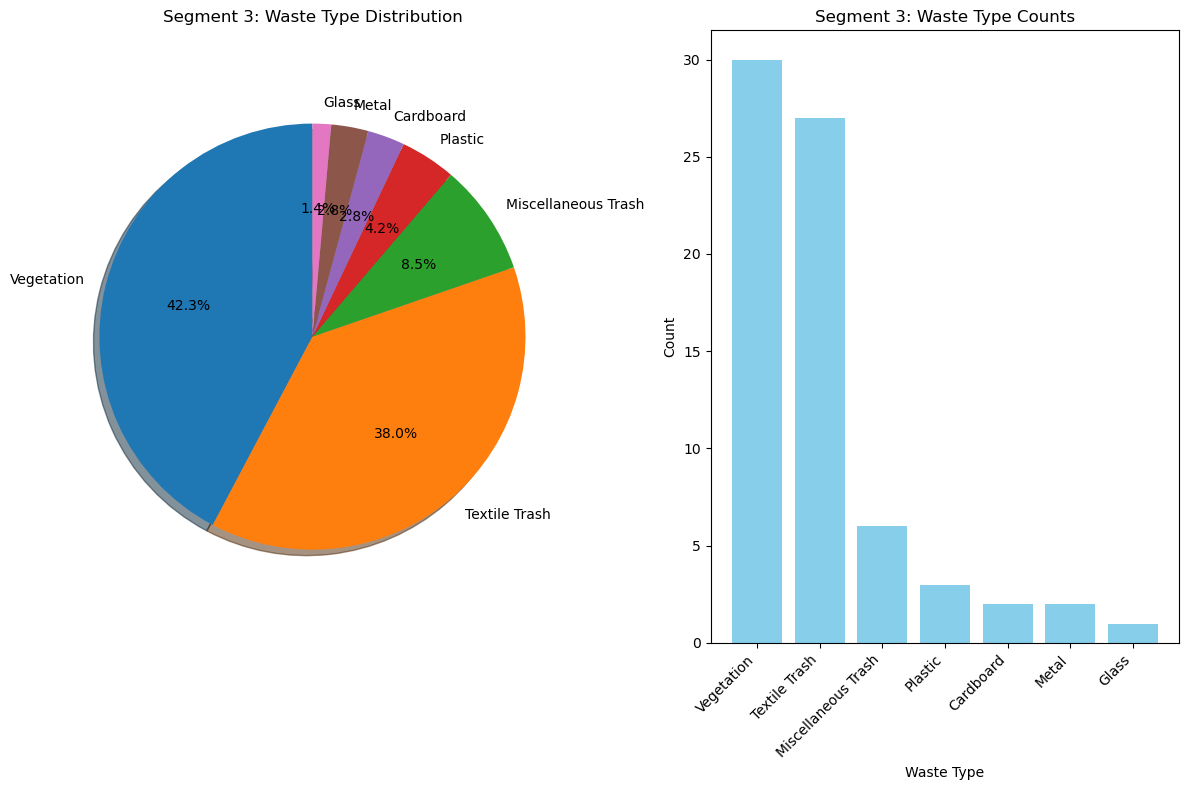

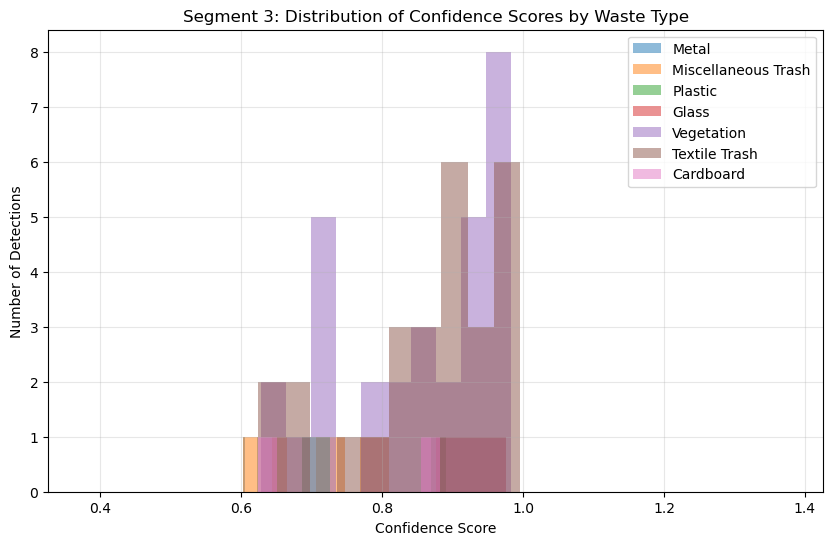



Analyzing Segment 4...

===== Segment 4: Waste Analysis Results =====
Total objects detected: 65
Most common waste type: Textile Trash (27 objects, 41.5%)

Detailed breakdown:
         Waste Type  Count  Percentage
      Textile Trash     27   41.538462
              Metal     13   20.000000
         Vegetation     13   20.000000
            Plastic      7   10.769231
Miscellaneous Trash      4    6.153846
          Cardboard      1    1.538462


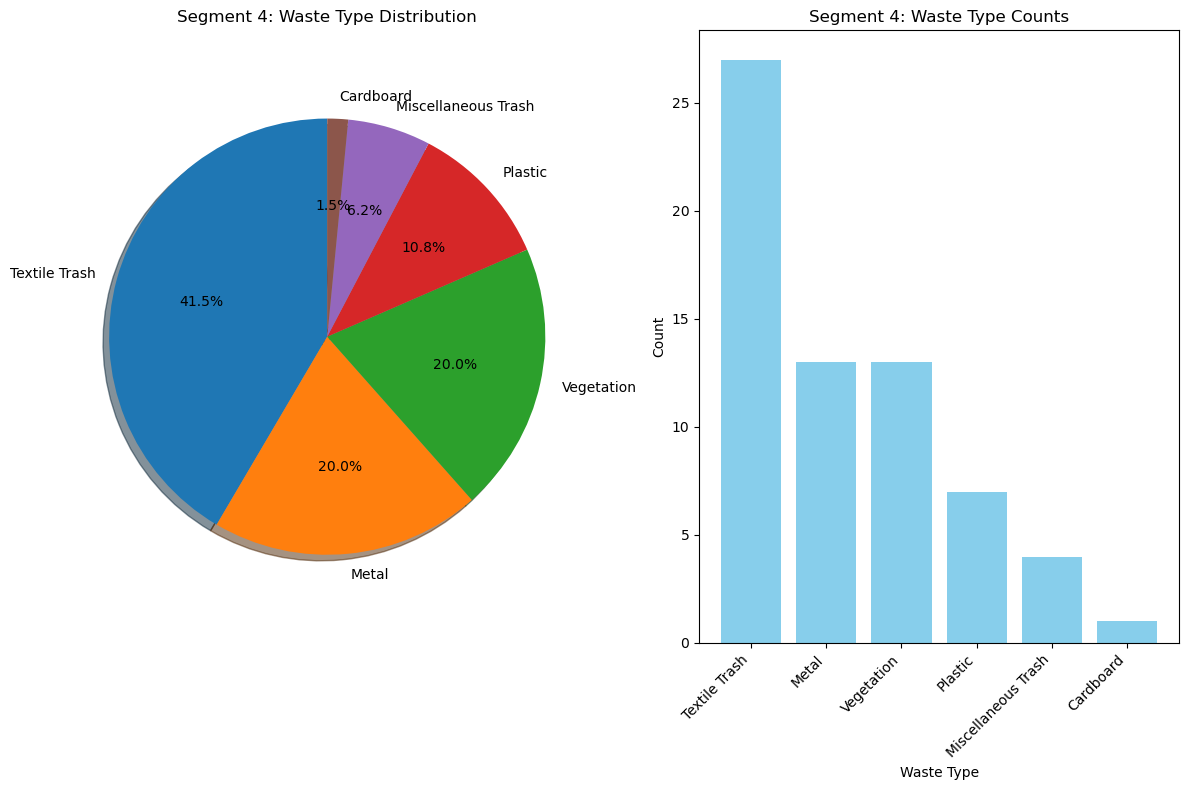

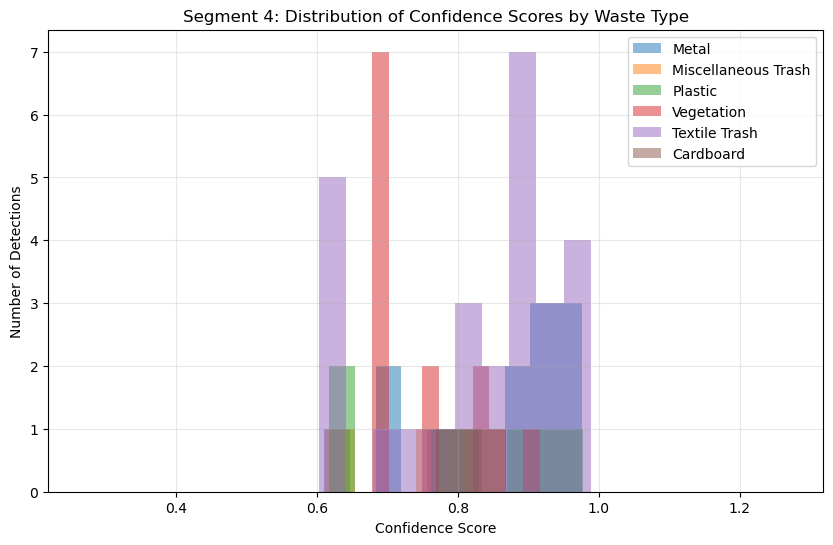



Analyzing All Segments Combined...

===== Waste Analysis Results =====
Total objects detected: 263
Most common waste type: Textile Trash (105 objects, 39.9%)

Detailed breakdown:
         Waste Type  Count  Percentage
      Textile Trash    105   39.923954
         Vegetation     55   20.912548
              Metal     35   13.307985
            Plastic     30   11.406844
Miscellaneous Trash     16    6.083650
              Glass     12    4.562738
          Cardboard      8    3.041825
              Paper      2    0.760456


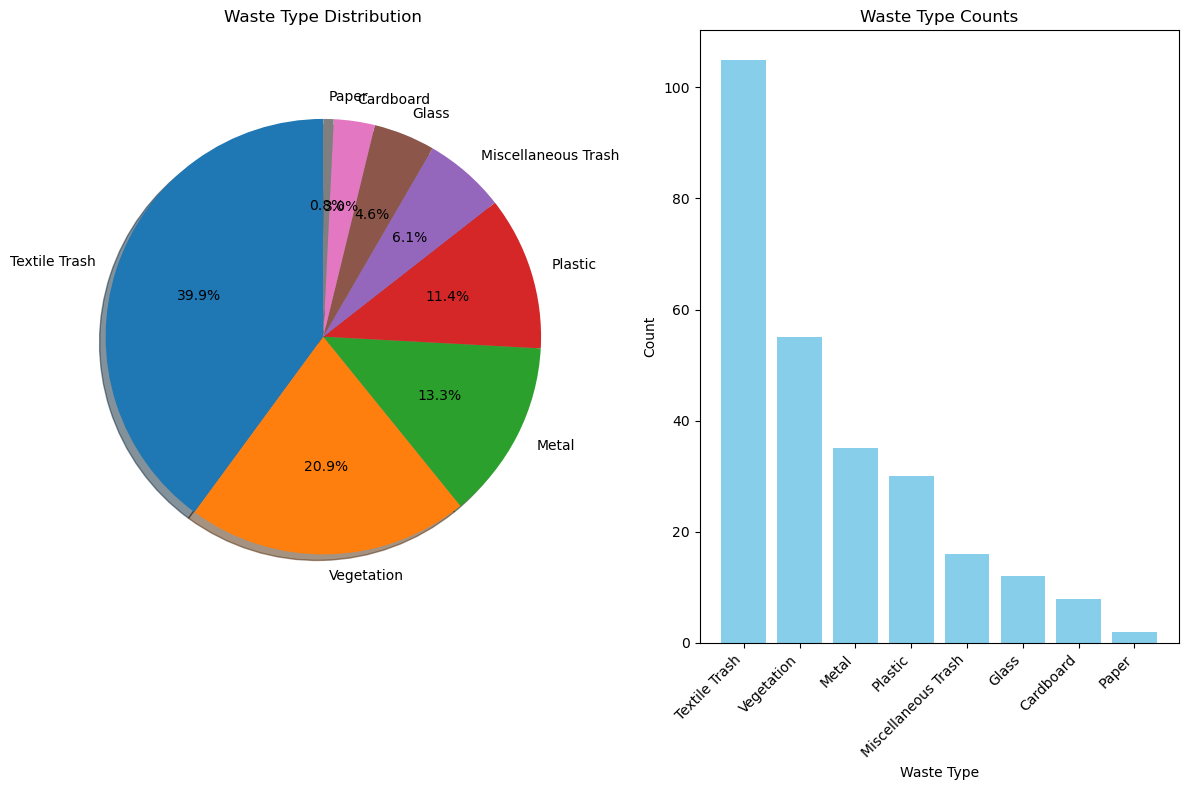

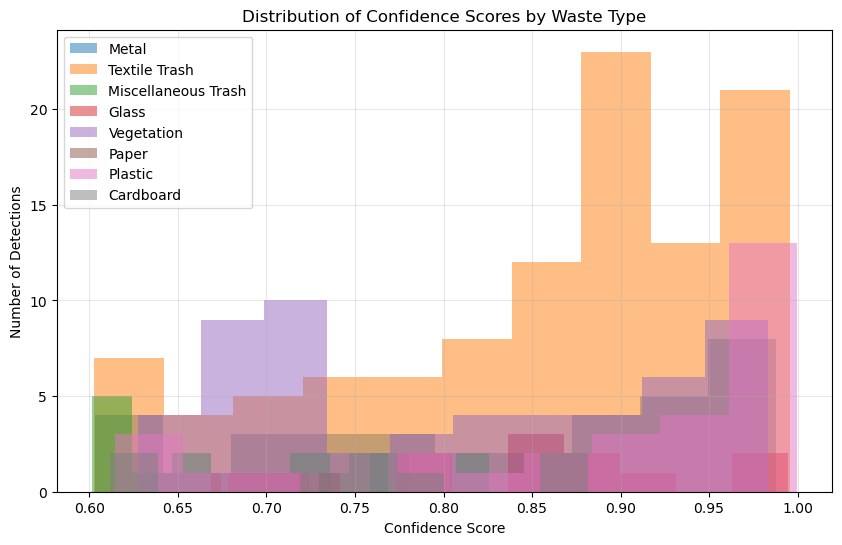

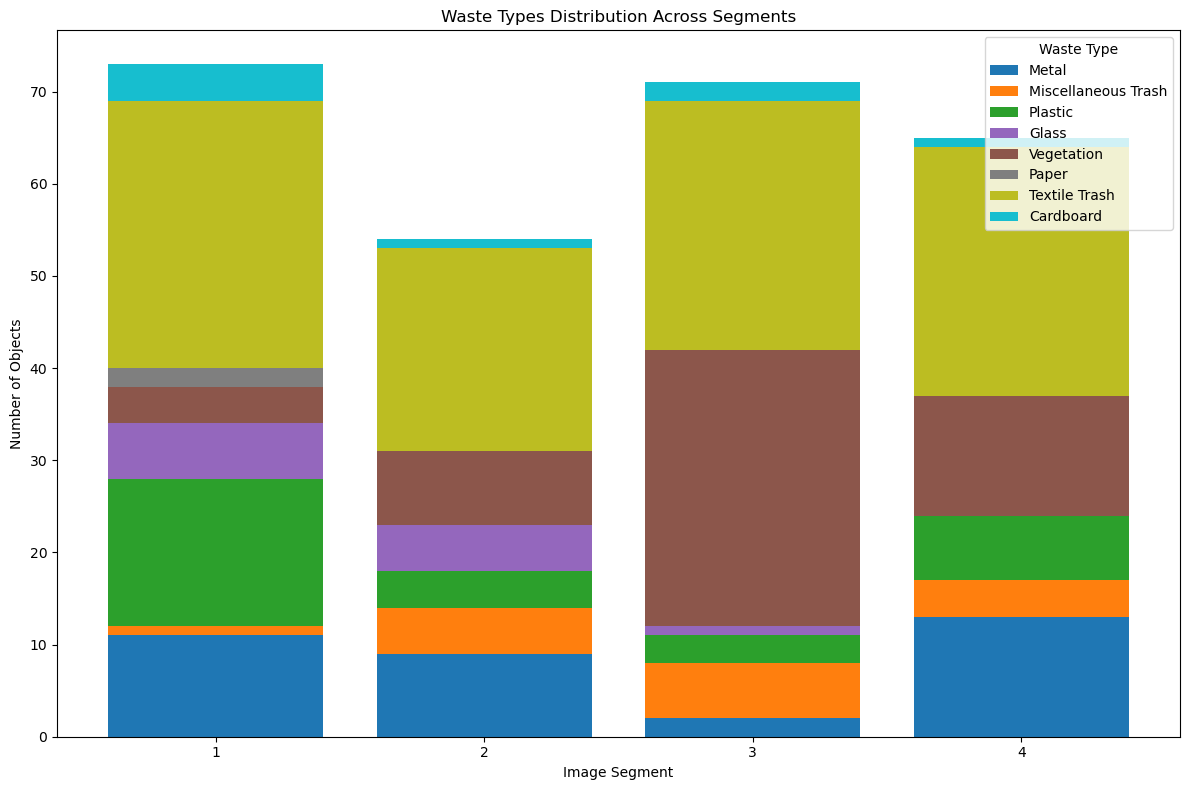

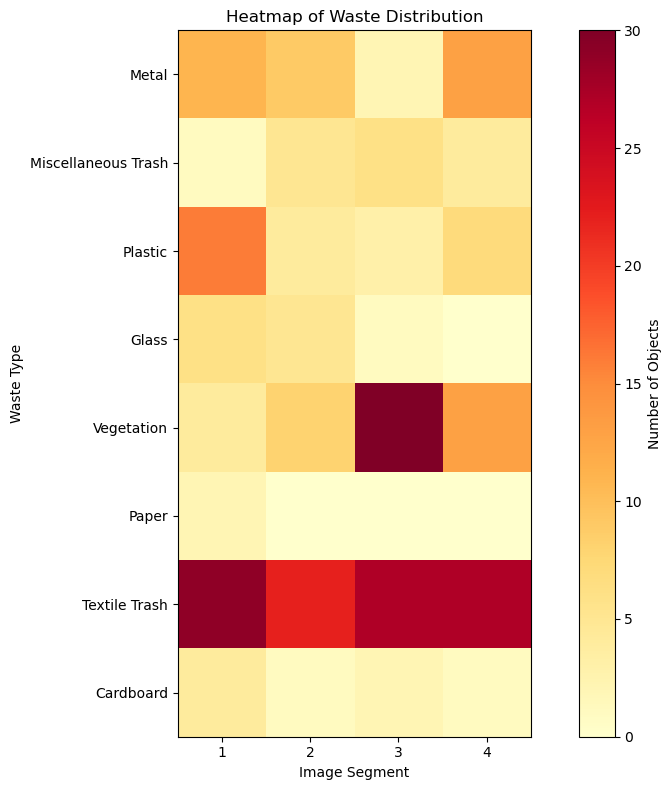


Overall analysis results saved to images\waste_analysis_results.csv
Segment 1 analysis saved to images\segment_1_analysis.csv
Segment 2 analysis saved to images\segment_2_analysis.csv
Segment 3 analysis saved to images\segment_3_analysis.csv
Segment 4 analysis saved to images\segment_4_analysis.csv

Total detections across all segments: 263


In [87]:
import pandas as pd
from collections import Counter
import os

def analyze_waste_detections(detections, class_names, segment_name=None):
    """
    Analyze the detected waste objects to determine the most common types
    
    Args:
        detections: List of detection results from approximate_multi_object_detection
        class_names: List of class names from the model
        segment_name: Name of the segment being analyzed (optional)
    
    Returns:
        DataFrame with analysis results
    """
    title_prefix = f"Segment {segment_name}: " if segment_name else ""
    file_prefix = f"segment_{segment_name}_" if segment_name else ""
    
    if not detections or len(detections) == 0:
        print(f"No detections found in {title_prefix or 'any segments'}!")
        return None
    
    # Extract waste types and confidences
    waste_types = [d['class'] for d in detections]
    confidences = [d['confidence'] for d in detections]
    
    # Count occurrences of each waste type
    waste_counts = Counter(waste_types)
    
    # Create DataFrame for better analysis
    df = pd.DataFrame({
        'Waste Type': list(waste_counts.keys()),
        'Count': list(waste_counts.values()),
        'Percentage': [count/len(waste_types)*100 for count in waste_counts.values()]
    })
    
    # Sort by count in descending order
    df = df.sort_values('Count', ascending=False)
    
    # Identify the most common type
    most_common = df.iloc[0]['Waste Type']
    most_common_count = df.iloc[0]['Count']
    most_common_pct = df.iloc[0]['Percentage']
    
    # Print summary statistics
    print(f"\n===== {title_prefix}Waste Analysis Results =====")
    print(f"Total objects detected: {len(waste_types)}")
    print(f"Most common waste type: {most_common} ({most_common_count} objects, {most_common_pct:.1f}%)")
    print("\nDetailed breakdown:")
    print(df.to_string(index=False))
    
    # Create visualizations
    plt.figure(figsize=(12, 8))
    
    # Pie chart
    plt.subplot(1, 2, 1)
    plt.pie(df['Count'], labels=df['Waste Type'], autopct='%1.1f%%', 
            shadow=True, startangle=90)
    plt.axis('equal')
    plt.title(f'{title_prefix}Waste Type Distribution')
    
    # Bar chart
    plt.subplot(1, 2, 2)
    plt.bar(df['Waste Type'], df['Count'], color='skyblue')
    plt.xlabel('Waste Type')
    plt.ylabel('Count')
    plt.title(f'{title_prefix}Waste Type Counts')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(os.path.join(images_dir, f"{file_prefix}waste_analysis.png"))
    plt.show()
    
    # Confidence distribution
    plt.figure(figsize=(10, 6))
    for waste_type in set(waste_types):
        type_confidences = [conf for typ, conf in zip(waste_types, confidences) if typ == waste_type]
        plt.hist(type_confidences, alpha=0.5, label=waste_type, bins=10)
    
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Detections')
    plt.title(f'{title_prefix}Distribution of Confidence Scores by Waste Type')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(images_dir, f"{file_prefix}confidence_distribution.png"))
    plt.show()
    
    return df

def analyze_segments(segment_paths, segment_detections, class_names):
    """
    Analyze waste types for each segment and across all segments
    
    Args:
        segment_paths: List of paths to segment images
        segment_detections: List of detection results for each segment
        class_names: List of class names from the model
    """
    # Create a dictionary to store segment analysis results
    segment_analyses = {}
    
    # Analyze each segment individually
    for i, (path, detections) in enumerate(zip(segment_paths, segment_detections)):
        segment_name = f"{i+1}"
        print(f"\n\nAnalyzing Segment {segment_name}...")
        segment_analyses[segment_name] = analyze_waste_detections(detections, class_names, segment_name)
    
    # Combine all detections for overall analysis
    all_detections = []
    for detections in segment_detections:
        all_detections.extend(detections)
    
    # Analyze combined results
    print("\n\nAnalyzing All Segments Combined...")
    overall_analysis = analyze_waste_detections(all_detections, class_names)
    
    # Create comparison visualization of waste distribution across segments
    create_segment_comparison(segment_analyses, overall_analysis)
    
    # Export results to CSV for further analysis if needed
    if overall_analysis is not None:
        csv_path = os.path.join(images_dir, "waste_analysis_results.csv")
        overall_analysis.to_csv(csv_path, index=False)
        print(f"\nOverall analysis results saved to {csv_path}")
        
        # Save individual segment analyses
        for segment_name, analysis in segment_analyses.items():
            if analysis is not None:
                seg_csv_path = os.path.join(images_dir, f"segment_{segment_name}_analysis.csv")
                analysis.to_csv(seg_csv_path, index=False)
                print(f"Segment {segment_name} analysis saved to {seg_csv_path}")

def create_segment_comparison(segment_analyses, overall_analysis):
    """
    Create visualization comparing waste types across different segments
    
    Args:
        segment_analyses: Dictionary of DataFrames with segment analysis results
        overall_analysis: DataFrame with overall analysis results
    """
    # Filter out None values
    segment_analyses = {k: v for k, v in segment_analyses.items() if v is not None}
    
    if not segment_analyses or overall_analysis is None:
        print("Not enough data for segment comparison")
        return
    
    # Get unique waste types across all segments
    all_waste_types = set()
    for df in segment_analyses.values():
        all_waste_types.update(df['Waste Type'])
    
    # Prepare data for stacked bar chart
    segments = list(segment_analyses.keys())
    waste_types = list(all_waste_types)
    
    # Create a matrix of counts
    data = np.zeros((len(waste_types), len(segments)))
    
    for i, waste_type in enumerate(waste_types):
        for j, segment in enumerate(segments):
            df = segment_analyses[segment]
            # Check if this waste type is in this segment
            if waste_type in df['Waste Type'].values:
                data[i, j] = df.loc[df['Waste Type'] == waste_type, 'Count'].iloc[0]
    
    # Plot stacked bar chart
    plt.figure(figsize=(12, 8))
    bottom = np.zeros(len(segments))
    
    # Use a colormap
    colors = plt.cm.tab10(np.linspace(0, 1, len(waste_types)))
    
    for i, waste_type in enumerate(waste_types):
        plt.bar(segments, data[i], bottom=bottom, label=waste_type, color=colors[i])
        bottom += data[i]
    
    plt.xlabel('Image Segment')
    plt.ylabel('Number of Objects')
    plt.title('Waste Types Distribution Across Segments')
    plt.legend(title='Waste Type')
    plt.tight_layout()
    plt.savefig(os.path.join(images_dir, "segment_comparison.png"))
    plt.show()
    
    # Create heatmap of waste distribution
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap='YlOrRd')
    plt.colorbar(label='Number of Objects')
    plt.xticks(np.arange(len(segments)), segments)
    plt.yticks(np.arange(len(waste_types)), waste_types)
    plt.xlabel('Image Segment')
    plt.ylabel('Waste Type')
    plt.title('Heatmap of Waste Distribution')
    plt.tight_layout()
    plt.savefig(os.path.join(images_dir, "waste_heatmap.png"))
    plt.show()

# Add this after running detection on each segment
print("\n\nAnalyzing waste types in each segment and overall...")

# Modify Step 4 to collect detections by segment
segment_detections = []
all_detections = []

for i, segment_path in enumerate(segment_paths):
    print(f"\nProcessing segment {i+1}...")
    detections = approximate_multi_object_detection(
        model, 
        segment_path, 
        class_names, 
        window_sizes=[32, 48, 64],
        stride=16,
        conf_threshold=0.6
    )
    segment_detections.append(detections)
    all_detections.extend(detections)

# Analyze segments
analyze_segments(segment_paths, segment_detections, class_names)

print(f"\nTotal detections across all segments: {len(all_detections)}")

In [89]:
# Save the model
torch.save(model.state_dict(), "garbage_classifier.pth")


In [70]:
#NEXT PART NOT WORKING
# Combine overlapping detections        

In [76]:
'''
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import cv2
import random

def segment_and_classify(image_path, classification_model, class_names, conf_threshold=0.7):
    

    
    # Set up segmentation model (Mask R-CNN)
    segmentation_model = maskrcnn_resnet50_fpn(pretrained=True)
    segmentation_model = segmentation_model.to(device)
    segmentation_model.eval()
    
    # Load and prepare image
    original_img = Image.open(image_path).convert("RGB")
    original_np = np.array(original_img)
    original_width, original_height = original_img.size
    
    # Transform for segmentation
    segmentation_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Transform for classification (same as used during training)
    classification_transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Same size as training
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Perform instance segmentation
    img_tensor = segmentation_transform(original_img).unsqueeze(0)
    with torch.no_grad():
        segmentation_results = segmentation_model(img_tensor.to(device))
    
    # Filter results by confidence
    boxes = segmentation_results[0]['boxes']
    scores = segmentation_results[0]['scores']
    masks = segmentation_results[0]['masks']
    
    # Only keep detections with high confidence
    keep = scores > conf_threshold
    boxes = boxes[keep].cpu().numpy().astype(np.int32)
    masks = masks[keep]
    scores = scores[keep].cpu().numpy()
    
    # Prepare for visualization
    plt.figure(figsize=(12, 12))
    plt.imshow(original_np)
    
    # Generate random colors for masks
    colors = []
    for i in range(len(boxes)):
        colors.append((random.random(), random.random(), random.random()))
    
    # Store results
    results = []
    
    # Process each detected object
    for i, (box, mask, score) in enumerate(zip(boxes, masks, scores)):
        x1, y1, x2, y2 = box
        
        # Ensure box is within image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(original_width, x2), min(original_height, y2)
        
        # Skip if box is too small
        if x2 - x1 < 20 or y2 - y1 < 20:
            continue
        
        # Extract mask and apply it to the image
        mask = mask[0].cpu().numpy() > 0.5
        
        # Create masked image of just this object
        masked_obj = original_np.copy()
        for c in range(3):  # Apply mask to each color channel
            masked_obj[:, :, c] = masked_obj[:, :, c] * mask
        
        # Crop to the bounding box
        masked_obj_cropped = masked_obj[y1:y2, x1:x2]
        
        # Convert to PIL for classification
        masked_obj_pil = Image.fromarray(masked_obj_cropped)
        
        # Classify the object
        obj_tensor = classification_transform(masked_obj_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = classification_model(obj_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            conf, pred_class = probs.max(1)
        
        waste_class = class_names[pred_class.item()]
        class_confidence = conf.item()
        
        # Store result
        results.append({
            'box': [x1, y1, x2, y2],
            'class': waste_class,
            'confidence': class_confidence,
            'detection_score': score
        })
        
        # Draw mask with transparency
        mask_color = np.zeros_like(original_np, dtype=np.uint8)
        mask_color[mask] = np.array([int(255 * colors[i][0]), 
                                     int(255 * colors[i][1]), 
                                     int(255 * colors[i][2])])
        
        # Overlay semi-transparent mask
        plt.imshow(mask_color, alpha=0.3)
        
        # Draw bounding box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1, 
            linewidth=2, edgecolor=colors[i], facecolor='none'
        )
        plt.gca().add_patch(rect)
        
        # Add label
        plt.text(
            x1, y1-5, 
            f"{waste_class}: {class_confidence:.2f}",
            color='white', 
            bbox=dict(facecolor=colors[i], alpha=0.8, pad=0.3, edgecolor='none')
        )
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return results

# Example usage
image_path = "rubbish-mound-overflowing-on-patio.webp"  # Change to your image path
results = segment_and_classify(image_path, model, class_names, conf_threshold=0.5)

# Print the results
for i, result in enumerate(results):
    print(f"Object {i+1}: Class = {result['class']}, Confidence = {result['confidence']:.2f}")"
'''

'\nimport torch\nimport torchvision\nfrom torchvision.models.detection import maskrcnn_resnet50_fpn\nimport matplotlib.pyplot as plt\nimport matplotlib.patches as patches\nimport numpy as np\nfrom PIL import Image\nimport cv2\nimport random\n\ndef segment_and_classify(image_path, classification_model, class_names, conf_threshold=0.7):\n    \n\n    \n    # Set up segmentation model (Mask R-CNN)\n    segmentation_model = maskrcnn_resnet50_fpn(pretrained=True)\n    segmentation_model = segmentation_model.to(device)\n    segmentation_model.eval()\n    \n    # Load and prepare image\n    original_img = Image.open(image_path).convert("RGB")\n    original_np = np.array(original_img)\n    original_width, original_height = original_img.size\n    \n    # Transform for segmentation\n    segmentation_transform = transforms.Compose([\n        transforms.ToTensor()\n    ])\n    \n    # Transform for classification (same as used during training)\n    classification_transform = transforms.Compose([\n 

In [75]:
'''
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision import transforms  # Make sure this is imported
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import cv2
import random

def segment_and_classify(image_path, classification_model, class_names, conf_threshold=0.5):
    """
    Segment objects in an image and classify each object using the classification model.
    
    Args:
        image_path: Path to the image
        classification_model: Trained classification model (MobileNetV2)
        class_names: List of class names for waste classification
        conf_threshold: Confidence threshold for object detection (lowered to capture more objects)
    """
    # Set up segmentation model (improved Mask R-CNN v2)
    segmentation_model = maskrcnn_resnet50_fpn_v2(pretrained=True, 
                                                 box_detections_per_img=100,  # Increase max detections
                                                 rpn_pre_nms_top_n_test=6000,  # Increase region proposals
                                                 rpn_post_nms_top_n_test=1000)  
    segmentation_model = segmentation_model.to(device)
    segmentation_model.eval()
    
    # Load and prepare image
    original_img = Image.open(image_path).convert("RGB")
    
    # Preprocess the image to enhance contrast
    original_np = np.array(original_img)
    enhanced_img = cv2.convertScaleAbs(original_np, alpha=1.2, beta=5)  # Enhance contrast
    original_img = Image.fromarray(enhanced_img)
    original_np = np.array(original_img)  # Update numpy array
    
    original_width, original_height = original_img.size
    
    # Transform for segmentation
    segmentation_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Transform for classification (same as used during training)
    classification_transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Add this back - it was missing!
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Perform instance segmentation
    img_tensor = segmentation_transform(original_img).unsqueeze(0)
    with torch.no_grad():
        segmentation_results = segmentation_model(img_tensor.to(device))
    
    # Filter results by confidence
    boxes = segmentation_results[0]['boxes']
    scores = segmentation_results[0]['scores']
    masks = segmentation_results[0]['masks']
    
    # Only keep detections with high confidence
    keep = scores > conf_threshold
    boxes = boxes[keep].cpu().numpy().astype(np.int32)
    masks = masks[keep]
    scores = scores[keep].cpu().numpy()
    
    # Prepare for visualization
    plt.figure(figsize=(15, 15))
    plt.imshow(original_np)
    
    # Generate random colors for masks with better visibility
    colors = []
    for i in range(len(boxes)):
        # Generate more vibrant colors
        r = random.uniform(0.6, 1.0)
        g = random.uniform(0.6, 1.0)
        b = random.uniform(0.6, 1.0)
        colors.append((r, g, b))
    
    # Store results
    results = []
    
    # Process each detected object
    for i, (box, mask, score) in enumerate(zip(boxes, masks, scores)):
        x1, y1, x2, y2 = box
        
        # Ensure box is within image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(original_width, x2), min(original_height, y2)
        
        # Skip if box is too small (reduced minimum size)
        if x2 - x1 < 15 or y2 - y1 < 15:
            continue
        
        # Extract mask and refine it
        mask_array = mask[0].cpu().numpy()
        refined_mask = mask_array > 0.4  # Lower threshold to capture more of the object
        
        # Apply morphological operations to improve mask
        kernel = np.ones((3, 3), np.uint8)
        refined_mask = cv2.morphologyEx(refined_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
        refined_mask = refined_mask.astype(bool)
        
        # Create masked image of just this object
        masked_obj = original_np.copy()
        
        # Only apply the mask where it's true
        for c in range(3):
            masked_channel = masked_obj[:, :, c]
            masked_channel[~refined_mask] = 0  # Set background to black
        
        # Crop to the bounding box
        masked_obj_cropped = masked_obj[y1:y2, x1:x2]
        
        # Skip empty or near-empty crops
        if np.sum(masked_obj_cropped) < 100:
            continue
        
        # Convert to PIL for classification
        masked_obj_pil = Image.fromarray(masked_obj_cropped)
        
        # Classify the object
        try:
            obj_tensor = classification_transform(masked_obj_pil).unsqueeze(0).to(device)
            with torch.no_grad():
                outputs = classification_model(obj_tensor)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                conf, pred_class = probs.max(1)
            
            waste_class = class_names[pred_class.item()]
            class_confidence = conf.item()
        except Exception as e:
            print(f"Error classifying object: {e}")
            continue
        
        # Store result
        results.append({
            'box': [x1, y1, x2, y2],
            'class': waste_class,
            'confidence': class_confidence,
            'detection_score': score
        })
        
        # Draw mask with transparency
        mask_color = np.zeros_like(original_np, dtype=np.uint8)
        mask_color[refined_mask] = np.array([int(255 * colors[i][0]), 
                                           int(255 * colors[i][1]), 
                                           int(255 * colors[i][2])])
        
        # Overlay semi-transparent mask
        plt.imshow(mask_color, alpha=0.4)  # Increased opacity
        
        # Draw bounding box with thicker lines
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1, 
            linewidth=2.5, edgecolor=colors[i], facecolor='none'
        )
        plt.gca().add_patch(rect)
        
        # Add label with better visibility
        plt.text(
            x1, y1-5, 
            f"{waste_class}: {class_confidence:.2f}",
            color='white', fontsize=10, fontweight='bold',
            bbox=dict(facecolor=colors[i], alpha=0.9, pad=0.5, edgecolor='none')
        )
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return results

# Try multi-scale detection to improve segmentation
def multi_scale_segment_and_classify(image_path, classification_model, class_names, conf_threshold=0.5):
    """
    Run segmentation at multiple scales for better results
    """
    # Original resolution
    print(f"Segmenting and classifying objects in {image_path}...")
    results1 = segment_and_classify(image_path, classification_model, class_names, conf_threshold)
    
    # Load image
    img = Image.open(image_path).convert("RGB")
    
    # Save a higher resolution version if needed
    try:
        width, height = img.size
        scale_factor = 1.5
        img_large = img.resize((int(width * scale_factor), int(height * scale_factor)), Image.LANCZOS)
        large_path = image_path.replace(".jpg", "_large.jpg").replace(".webp", "_large.jpg")
        img_large.save(large_path)
        print(f"Saved high-resolution version to {large_path}")
    except Exception as e:
        print(f"Failed to save high-res version: {e}")
    
    print(f"Found {len(results1)} objects in the image")
    return results1

# Example usage
image_path = "rubbish-mound-overflowing-on-patio.webp"  # Change to your image path
results = multi_scale_segment_and_classify(image_path, model, class_names, conf_threshold=0.35)

# Print the results
for i, result in enumerate(results):
    print(f"Object {i+1}: Class = {result['class']}, Confidence = {result['confidence']:.2f}")'
    '''

'\nimport torch\nimport torchvision\nfrom torchvision.models.detection import maskrcnn_resnet50_fpn_v2\nfrom torchvision import transforms  # Make sure this is imported\nimport matplotlib.pyplot as plt\nimport matplotlib.patches as patches\nimport numpy as np\nfrom PIL import Image\nimport cv2\nimport random\n\ndef segment_and_classify(image_path, classification_model, class_names, conf_threshold=0.5):\n    """\n    Segment objects in an image and classify each object using the classification model.\n    \n    Args:\n        image_path: Path to the image\n        classification_model: Trained classification model (MobileNetV2)\n        class_names: List of class names for waste classification\n        conf_threshold: Confidence threshold for object detection (lowered to capture more objects)\n    """\n    # Set up segmentation model (improved Mask R-CNN v2)\n    segmentation_model = maskrcnn_resnet50_fpn_v2(pretrained=True, \n                                                 box_detecti

In [74]:

'''import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image
import matplotlib.colors as mcolors
import random

# Import Mask R-CNN model for segmentation
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision import transforms

def segment_and_classify_image(image_path, classification_model, class_names, conf_threshold=0.5, show_visualization=True):
    """
    Segment objects in an image and classify each object using the pre-trained classification model.
    
    Args:
        image_path: Path to the image
        classification_model: Pre-trained classification model (MobileNetV2)
        class_names: List of class names for the classifier
        conf_threshold: Confidence threshold for detection
        show_visualization: Whether to display the visualization
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    classification_model = classification_model.to(device)
    classification_model.eval()
    
    # Load segmentation model
    segmentation_model = maskrcnn_resnet50_fpn(pretrained=True)
    segmentation_model = segmentation_model.to(device)
    segmentation_model.eval()
    
    # Load the image
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    
    # Prepare transforms
    seg_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Transform for classification (must match what was used during training)
    cls_transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Same as in training
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Perform segmentation
    img_tensor = seg_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        predictions = segmentation_model(img_tensor)
    
    # Get predictions
    pred_boxes = predictions[0]['boxes'].cpu().detach()
    pred_scores = predictions[0]['scores'].cpu().detach()
    pred_masks = predictions[0]['masks'].cpu().detach()
    
    # Filter by confidence threshold
    keep_idxs = pred_scores > conf_threshold
    boxes = pred_boxes[keep_idxs].numpy().astype(np.int32)
    scores = pred_scores[keep_idxs].numpy()
    masks = pred_masks[keep_idxs]
    
    # Create a visualization
    if show_visualization:
        fig, ax = plt.subplots(1, figsize=(16, 16))
        ax.imshow(image_np)
        
        # Generate colors for each class
        unique_colors = list(mcolors.TABLEAU_COLORS.values())
        
    # Results list
    results = []
    
    # Process each detected object
    for i, (box, mask, score) in enumerate(zip(boxes, masks, scores)):
        x1, y1, x2, y2 = box
        
        # Skip very small detections
        if (x2 - x1 < 20) or (y2 - y1 < 20):
            continue
            
        # Get binary mask (single channel)
        mask_np = mask[0].numpy() > 0.5
        
        # Create a cropped image of the detected object
        cropped = image.crop((x1, y1, x2, y2))
        
        try:
            # Save debug image
            debug_path = f"debug_object_{i}.jpg"
            cropped.save(debug_path)
            print(f"Saved detected object {i} to {debug_path}")
            
            # Apply classification transform and classify
            input_tensor = cls_transform(cropped).unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = classification_model(input_tensor)
                probabilities = torch.nn.functional.softmax(output, dim=1)
                confidence, predicted_class = torch.max(probabilities, 1)
            
            class_name = class_names[predicted_class.item()]
            class_conf = confidence.item()
            
            result = {
                "box": box.tolist(),
                "class": class_name,
                "confidence": class_conf,
                "segmentation_score": score
            }
            results.append(result)
            
            # Visualization
            if show_visualization:
                # Get color for this class
                color_idx = predicted_class.item() % len(unique_colors)
                color = unique_colors[color_idx]
                
                # Create mask for visualization
                colored_mask = np.zeros_like(image_np, dtype=np.uint8)
                mask_area = np.where(mask_np)
                if len(mask_area[0]) > 0:  # Check if mask is not empty
                    for c in range(3):
                        colored_mask[:, :, c][mask_area] = np.array(mcolors.to_rgb(color))[c] * 255
                
                # Add alpha mask
                ax.imshow(colored_mask, alpha=0.4)
                
                # Add bounding box
                rect = patches.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    linewidth=2, edgecolor=color, facecolor='none'
                )
                ax.add_patch(rect)
                
                # Add label
                ax.text(
                    x1, y1-10, 
                    f"{class_name}: {class_conf:.2f}",
                    color='white', fontsize=12, fontweight='bold',
                    bbox={'facecolor': color, 'alpha': 0.8, 'pad': 2, 'edgecolor': 'none'}
                )
                
        except Exception as e:
            print(f"Error processing object {i}: {e}")
    
    if show_visualization:
        plt.axis('off')
        plt.tight_layout()
        plt.savefig("segmentation_result.jpg", dpi=300, bbox_inches='tight')
        plt.show()
    
    return results

# Function to display an overview of results
def display_results_summary(results, image_path):
    """Display a summary of detected waste types"""
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    
    # Count waste types
    waste_types = {}
    for result in results:
        waste_class = result["class"]
        if waste_class in waste_types:
            waste_types[waste_class] += 1
        else:
            waste_types[waste_class] = 1
    
    # Print summary
    print(f"\nWaste Classification Summary:")
    print(f"Found {len(results)} objects in the image")
    print("-" * 40)
    
    for waste_type, count in waste_types.items():
        print(f"{waste_type}: {count} objects")
    
    # Show small summary visualization
    plt.figure(figsize=(8, 4))
    plt.bar(waste_types.keys(), waste_types.values(), color='skyblue')
    plt.title('Types of Waste Detected')
    plt.xlabel('Waste Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("waste_summary.jpg")
    plt.show()

# Use the functions on your image
image_path = "1200px-Pile_of_trash_2.jpg"  # Replace with your image path
results = segment_and_classify_image(image_path, model, class_names, conf_threshold=0.5)

# Display results summary
display_results_summary(results, image_path)'
'''

'import torch\nimport torchvision\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport matplotlib.patches as patches\nimport cv2\nfrom PIL import Image\nimport matplotlib.colors as mcolors\nimport random\n\n# Import Mask R-CNN model for segmentation\nfrom torchvision.models.detection import maskrcnn_resnet50_fpn\nfrom torchvision import transforms\n\ndef segment_and_classify_image(image_path, classification_model, class_names, conf_threshold=0.5, show_visualization=True):\n    """\n    Segment objects in an image and classify each object using the pre-trained classification model.\n    \n    Args:\n        image_path: Path to the image\n        classification_model: Pre-trained classification model (MobileNetV2)\n        class_names: List of class names for the classifier\n        conf_threshold: Confidence threshold for detection\n        show_visualization: Whether to display the visualization\n    """\n    # Set device\n    device = torch.device("cuda" if torch.cuda.is_avail